# Chapter 7: The Hardware Battlefield

**Pocket Agents: A Practical Guide to On‑Device Artificial Intelligence**

This notebook demonstrates hardware-specific optimizations and comparisons for on-device AI deployment across different platforms: CPU, GPU, NPU, and mobile devices.

## 🚀 Quick Setup Instructions

### Option 1: Automated Setup (Recommended)
```bash
# Navigate to this directory
cd companion-code/chapters/chapter-07

# Run the setup script (creates venv, installs dependencies, launches Jupyter)
./setup_and_test.sh
```

### Option 2: Manual Setup
```bash
# 1. Create virtual environment
python3 -m venv venv

# 2. Activate virtual environment
source venv/bin/activate  # On Windows: venv\Scripts\activate

# 3. Install dependencies
pip install -r requirements.txt

# 4. Launch Jupyter notebook
jupyter notebook hardware_battlefield_demo.ipynb
```

### 📋 Required Dependencies
- **PyTorch** (≥2.0.0) - For neural network operations
- **NumPy** (≥1.21.0) - For numerical computations
- **Matplotlib** (≥3.5.0) - For visualizations
- **Psutil** (≥5.8.0) - For system monitoring
- **Jupyter** (≥1.0.0) - For interactive notebooks

## What You'll Learn
- Hardware-specific optimization techniques
- Performance comparisons across different platforms
- Memory usage and power consumption analysis
- Real-world deployment considerations
- Platform-specific best practices

## 🔧 Troubleshooting

### Common Issues:
- **"Command not found"**: Make sure you're in the correct directory
- **"Permission denied"**: Run `chmod +x setup_and_test.sh` first
- **"Python not found"**: Install Python 3.8+ from python.org
- **"Jupyter not launching"**: Try `jupyter lab` instead of `jupyter notebook`
- **"ModuleNotFoundError"**: Make sure you're using the correct kernel (see below)

### ⚠️ IMPORTANT: Kernel Setup
If you get "ModuleNotFoundError" when running cells:

1. **Check the kernel** in the top-right corner of Jupyter
2. **Select the correct kernel**: Look for "Python (venv)" or similar
3. **If not available**, run this in terminal:
   ```bash
   source venv/bin/activate
   python -m ipykernel install --user --name=venv --display-name="Python (venv)"
   ```
4. **Restart Jupyter** and select the "Python (venv)" kernel

### System Requirements:
- **Python**: 3.8 or higher
- **RAM**: At least 4GB (8GB recommended)
- **Disk Space**: ~2GB for dependencies

---


In [1]:
# 🔧 KERNEL CHECK - Run this first if you get import errors!
import sys
print(f"🐍 Python executable: {sys.executable}")
print(f"📦 Python path: {sys.path[0]}")

# Check if we're in a virtual environment
if 'venv' in sys.executable or 'env' in sys.executable:
    print("✅ Running in virtual environment")
else:
    print("⚠️ WARNING: Not running in virtual environment!")
    print("   Please make sure you activated the venv and selected the correct kernel")
    print("   Go to Kernel → Change Kernel → Python (venv)")

# Test imports
try:
    import torch
    print(f"✅ PyTorch version: {torch.__version__}")
except ImportError:
    print("❌ PyTorch not found - check your kernel selection!")

try:
    import numpy as np
    print(f"✅ NumPy version: {np.__version__}")
except ImportError:
    print("❌ NumPy not found - check your kernel selection!")

try:
    import matplotlib.pyplot as plt
    print(f"✅ Matplotlib version: {plt.matplotlib.__version__}")
except ImportError:
    print("❌ Matplotlib not found - check your kernel selection!")

try:
    import psutil
    print(f"✅ Psutil version: {psutil.__version__}")
except ImportError:
    print("❌ Psutil not found - check your kernel selection!")

# Import all required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
from typing import Dict, List, Tuple

print("🔧 Chapter 7: The Hardware Battlefield")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
print("✅ All imports successful!")


🐍 Python executable: /Users/freddyayala/Documents/GitHub/slm-ebook/companion-code/chapters/chapter-09/venv/bin/python
📦 Python path: /opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python313.zip
✅ Running in virtual environment
✅ PyTorch version: 2.9.0
✅ NumPy version: 2.3.4
✅ Matplotlib version: 3.10.7
✅ Psutil version: 7.1.1
🔧 Chapter 7: The Hardware Battlefield
PyTorch version: 2.9.0
CUDA available: False
✅ All imports successful!


## 2. Understanding the Hardware Battlefield

### The On-Device AI Hardware Landscape

On-device AI deployment spans multiple hardware platforms, each with unique characteristics:

1. **CPU (Central Processing Unit)**
   - **Pros**: Universal compatibility, low power consumption, predictable performance
   - **Cons**: Limited parallel processing, slower for large models
   - **Best for**: Small models, real-time applications, battery-powered devices

2. **GPU (Graphics Processing Unit)**
   - **Pros**: Massive parallel processing, high throughput, excellent for large models
   - **Cons**: High power consumption, limited mobile availability, complex deployment
   - **Best for**: Desktop applications, server deployment, large model inference

3. **NPU (Neural Processing Unit)**
   - **Pros**: Optimized for AI workloads, low power consumption, high efficiency
   - **Cons**: Limited availability, platform-specific, smaller ecosystem
   - **Best for**: Mobile devices, edge computing, power-constrained environments

4. **Mobile SoC (System on Chip)**
   - **Pros**: Integrated solution, optimized for mobile, balanced performance
   - **Cons**: Limited compute power, thermal constraints, platform-specific
   - **Best for**: Smartphones, tablets, IoT devices

### Key Performance Metrics

- **Latency**: Time to first token (TTFT)
- **Throughput**: Tokens per second
- **Memory Usage**: RAM consumption
- **Power Consumption**: Energy per token
- **Thermal Impact**: Heat generation


In [2]:
# Create a test model for hardware comparison
class HardwareTestModel(nn.Module):
    """A test model for hardware performance comparison"""
    
    def __init__(self, input_size=100, hidden_sizes=[128, 64, 32], output_size=10):
        super().__init__()
        
        # Create layers dynamically
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def get_model_info(self):
        """Get model information"""
        total_params = sum(p.numel() for p in self.parameters())
        model_size = sum(p.numel() * p.element_size() for p in self.parameters())
        
        return {
            'total_params': total_params,
            'model_size_bytes': model_size,
            'model_size_mb': model_size / (1024 * 1024)
        }

# Create test model and data
test_model = HardwareTestModel(input_size=100, hidden_sizes=[128, 64, 32], output_size=10)
input_data = torch.randn(1, 100)

print("🏗️ Hardware Test Model Created:")
model_info = test_model.get_model_info()
print(f"   Total parameters: {model_info['total_params']:,}")
print(f"   Model size: {model_info['model_size_mb']:.2f} MB")
print(f"   Input shape: {input_data.shape}")

# Test forward pass
test_model.eval()
with torch.no_grad():
    output = test_model(input_data)
    print(f"   Output shape: {output.shape}")
    print("✅ Model created and tested successfully!")


🏗️ Hardware Test Model Created:
   Total parameters: 23,594
   Model size: 0.09 MB
   Input shape: torch.Size([1, 100])
   Output shape: torch.Size([1, 10])
✅ Model created and tested successfully!


## 3. CPU Performance Analysis

### CPU: The Universal Workhorse

CPU inference is the most universally compatible approach for on-device AI. Let's analyze CPU performance characteristics and optimization techniques.


In [3]:
# CPU Performance Benchmark
def benchmark_cpu_performance(model, input_data, num_iterations=1000):
    """Benchmark CPU performance"""
    
    model.eval()
    model.cpu()  # Ensure model is on CPU
    
    # Get system information
    cpu_count = psutil.cpu_count()
    cpu_freq = psutil.cpu_freq()
    memory = psutil.virtual_memory()
    
    print("🖥️ CPU System Information:")
    print(f"   CPU cores: {cpu_count}")
    print(f"   CPU frequency: {cpu_freq.current:.0f} MHz" if cpu_freq else "   CPU frequency: Unknown")
    print(f"   Total RAM: {memory.total / (1024**3):.1f} GB")
    print(f"   Available RAM: {memory.available / (1024**3):.1f} GB")
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)
    
    # Benchmark
    times = []
    memory_usage = []
    
    with torch.no_grad():
        for _ in range(num_iterations):
            # Monitor memory before inference
            memory_before = psutil.virtual_memory().used
            
            start_time = time.time()
            output = model(input_data)
            end_time = time.time()
            
            # Monitor memory after inference
            memory_after = psutil.virtual_memory().used
            
            times.append(end_time - start_time)
            memory_usage.append(memory_after - memory_before)
    
    return {
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'throughput': 1.0 / np.mean(times),
        'mean_memory': np.mean(memory_usage),
        'max_memory': np.max(memory_usage)
    }

# Run CPU benchmark
print("🔥 CPU Performance Benchmark")
print("=" * 50)

cpu_results = benchmark_cpu_performance(test_model, input_data)

print(f"\n📊 CPU Performance Results:")
print(f"   Mean inference time: {cpu_results['mean_time'] * 1000:.2f} ms")
print(f"   Std deviation: {cpu_results['std_time'] * 1000:.2f} ms")
print(f"   Min time: {cpu_results['min_time'] * 1000:.2f} ms")
print(f"   Max time: {cpu_results['max_time'] * 1000:.2f} ms")
print(f"   Throughput: {cpu_results['throughput']:.1f} inferences/sec")
print(f"   Mean memory usage: {cpu_results['mean_memory'] / 1024:.1f} KB")
print(f"   Max memory usage: {cpu_results['max_memory'] / 1024:.1f} KB")

print("\n✅ CPU benchmark completed!")


🔥 CPU Performance Benchmark
🖥️ CPU System Information:
   CPU cores: 12
   CPU frequency: 3696 MHz
   Total RAM: 64.0 GB
   Available RAM: 28.3 GB

📊 CPU Performance Results:
   Mean inference time: 0.03 ms
   Std deviation: 0.01 ms
   Min time: 0.03 ms
   Max time: 0.16 ms
   Throughput: 29711.2 inferences/sec
   Mean memory usage: 0.0 KB
   Max memory usage: 16.0 KB

✅ CPU benchmark completed!


## 4. GPU Performance Analysis (If Available)

### GPU: The Parallel Processing Powerhouse

GPU inference offers massive parallel processing capabilities, but comes with trade-offs in power consumption and deployment complexity.


In [4]:
# GPU Performance Benchmark (Multiple Backends)
def benchmark_gpu_performance(model, input_data, num_iterations=1000):
    """Benchmark GPU performance across different backends"""
    import torch  # Import torch inside function to avoid scope issues
    
    # Check available GPU backends
    gpu_backends = []
    
    if torch.cuda.is_available():
        gpu_backends.append(('CUDA', 'cuda'))
    
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        gpu_backends.append(('MPS (Apple Silicon)', 'mps'))
    
    # Check for Intel XPU
    try:
        import torch.xpu
        if torch.xpu.is_available():
            gpu_backends.append(('Intel XPU', 'xpu'))
    except ImportError:
        pass
    
    # Check for ROCm (AMD)
    try:
        if torch.version.hip is not None:
            gpu_backends.append(('ROCm (AMD)', 'cuda'))  # ROCm uses CUDA API
    except:
        pass
    
    if not gpu_backends:
        print("❌ No GPU backends available - skipping GPU benchmark")
        return None
    
    # Test the first available GPU backend
    backend_name, device = gpu_backends[0]
    print(f"🎮 Using GPU Backend: {backend_name}")
    
    model.eval()
    model.to(device)  # Move model to GPU
    input_data_gpu = input_data.to(device)  # Move input to GPU
    
    # Get GPU information
    if device == 'cuda':
        gpu_count = torch.cuda.device_count()
        current_gpu = torch.cuda.current_device()
        gpu_name = torch.cuda.get_device_name(current_gpu)
        gpu_memory = torch.cuda.get_device_properties(current_gpu).total_memory
        
        print("🎮 GPU System Information:")
        print(f"   GPU count: {gpu_count}")
        print(f"   Current GPU: {current_gpu}")
        print(f"   GPU name: {gpu_name}")
        print(f"   GPU memory: {gpu_memory / (1024**3):.1f} GB")
    elif device == 'mps':
        print("🎮 MPS (Apple Silicon) Information:")
        print(f"   Backend: Metal Performance Shaders")
        print(f"   Device: Apple Silicon GPU")
    else:
        print(f"🎮 {backend_name} Information:")
        print(f"   Backend: {backend_name}")
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data_gpu)
    
    # Benchmark
    times = []
    memory_usage = []
    
    with torch.no_grad():
        for _ in range(num_iterations):
            # Monitor GPU memory before inference
            if device == 'cuda':
                memory_before = torch.cuda.memory_allocated()
            else:
                memory_before = 0  # MPS doesn't have memory tracking
            
            start_time = time.time()
            output = model(input_data_gpu)
            
            # Synchronize based on backend
            if device == 'cuda':
                torch.cuda.synchronize()
            elif device == 'mps':
                torch.mps.synchronize()
            
            end_time = time.time()
            
            # Monitor GPU memory after inference
            if device == 'cuda':
                memory_after = torch.cuda.memory_allocated()
                memory_usage.append(memory_after - memory_before)
            else:
                memory_usage.append(0)  # MPS doesn't have memory tracking
            
            times.append(end_time - start_time)
    
    return {
        'backend': backend_name,
        'device': device,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'throughput': 1.0 / np.mean(times),
        'mean_memory': np.mean(memory_usage),
        'max_memory': np.max(memory_usage)
    }

# Run GPU benchmark
print("🔥 GPU Performance Benchmark")
print("=" * 50)

gpu_results = benchmark_gpu_performance(test_model, input_data)

if gpu_results:
    print(f"\n📊 GPU Performance Results ({gpu_results['backend']}):")
    print(f"   Backend: {gpu_results['backend']}")
    print(f"   Device: {gpu_results['device']}")
    print(f"   Mean inference time: {gpu_results['mean_time'] * 1000:.2f} ms")
    print(f"   Std deviation: {gpu_results['std_time'] * 1000:.2f} ms")
    print(f"   Min time: {gpu_results['min_time'] * 1000:.2f} ms")
    print(f"   Max time: {gpu_results['max_time'] * 1000:.2f} ms")
    print(f"   Throughput: {gpu_results['throughput']:.1f} inferences/sec")
    
    if gpu_results['mean_memory'] > 0:
        print(f"   Mean memory usage: {gpu_results['mean_memory'] / 1024:.1f} KB")
        print(f"   Max memory usage: {gpu_results['max_memory'] / 1024:.1f} KB")
    else:
        print(f"   Memory tracking: Not available for {gpu_results['backend']}")
    
    print("\n✅ GPU benchmark completed!")
else:
    print("ℹ️ GPU benchmark skipped - No GPU backends available")


🔥 GPU Performance Benchmark
🎮 Using GPU Backend: MPS (Apple Silicon)
🎮 MPS (Apple Silicon) Information:
   Backend: Metal Performance Shaders
   Device: Apple Silicon GPU

📊 GPU Performance Results (MPS (Apple Silicon)):
   Backend: MPS (Apple Silicon)
   Device: mps
   Mean inference time: 0.37 ms
   Std deviation: 0.05 ms
   Min time: 0.34 ms
   Max time: 1.42 ms
   Throughput: 2707.4 inferences/sec
   Memory tracking: Not available for MPS (Apple Silicon)

✅ GPU benchmark completed!


In [5]:
# Check Available GPU Backends
def check_gpu_backends():
    """Check all available GPU backends"""
    import torch  # Import torch inside function to avoid scope issues
    
    print("🔍 Checking Available GPU Backends")
    print("=" * 50)
    
    backends = []
    
    # Check CUDA
    if torch.cuda.is_available():
        backends.append({
            'name': 'CUDA (NVIDIA)',
            'device': 'cuda',
            'available': True,
            'info': f"GPU count: {torch.cuda.device_count()}"
        })
        print(f"✅ CUDA available: {torch.cuda.device_count()} GPU(s)")
        for i in range(torch.cuda.device_count()):
            print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("❌ CUDA not available")
    
    # Check MPS (Apple Silicon)
    if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        backends.append({
            'name': 'MPS (Apple Silicon)',
            'device': 'mps',
            'available': True,
            'info': "Metal Performance Shaders"
        })
        print("✅ MPS (Apple Silicon) available")
    else:
        print("❌ MPS (Apple Silicon) not available")
    
    # Check Intel XPU
    try:
        import torch.xpu
        if torch.xpu.is_available():
            backends.append({
                'name': 'Intel XPU',
                'device': 'xpu',
                'available': True,
                'info': "Intel GPU computing"
            })
            print("✅ Intel XPU available")
        else:
            print("❌ Intel XPU not available")
    except ImportError:
        print("❌ Intel XPU not installed")
    
    # Check ROCm (AMD)
    try:
        if torch.version.hip is not None:
            backends.append({
                'name': 'ROCm (AMD)',
                'device': 'cuda',  # ROCm uses CUDA API
                'available': True,
                'info': "AMD GPU computing"
            })
            print("✅ ROCm (AMD) available")
        else:
            print("❌ ROCm (AMD) not available")
    except:
        print("❌ ROCm (AMD) not available")
    
    print(f"\n📊 Summary: {len(backends)} GPU backend(s) available")
    return backends

# Check available backends
available_backends = check_gpu_backends()

if available_backends:
    print("\n🎯 Available GPU backends for testing:")
    for backend in available_backends:
        print(f"   • {backend['name']}: {backend['info']}")
else:
    print("\nℹ️ No GPU backends available - will test CPU only")


🔍 Checking Available GPU Backends
❌ CUDA not available
✅ MPS (Apple Silicon) available
❌ Intel XPU not available
❌ ROCm (AMD) not available

📊 Summary: 1 GPU backend(s) available

🎯 Available GPU backends for testing:
   • MPS (Apple Silicon): Metal Performance Shaders


## 5. Hardware Performance Comparison

### Comparing CPU vs GPU Performance

Let's analyze the performance differences between CPU and GPU inference to understand the trade-offs.


📊 Hardware Performance Comparison
📊 Performance Comparison Table:
------------------------------------------------------------
Platform   Latency (ms)    Throughput (inf/s) Memory (KB) 
------------------------------------------------------------
CPU        0.03            29711.2            0.0         
GPU        0.37            2707.4             0.0         

🐌 GPU Slowdown: 10.97x slower
💾 Memory Usage: CPU uses memory, GPU doesn't track
------------------------------------------------------------


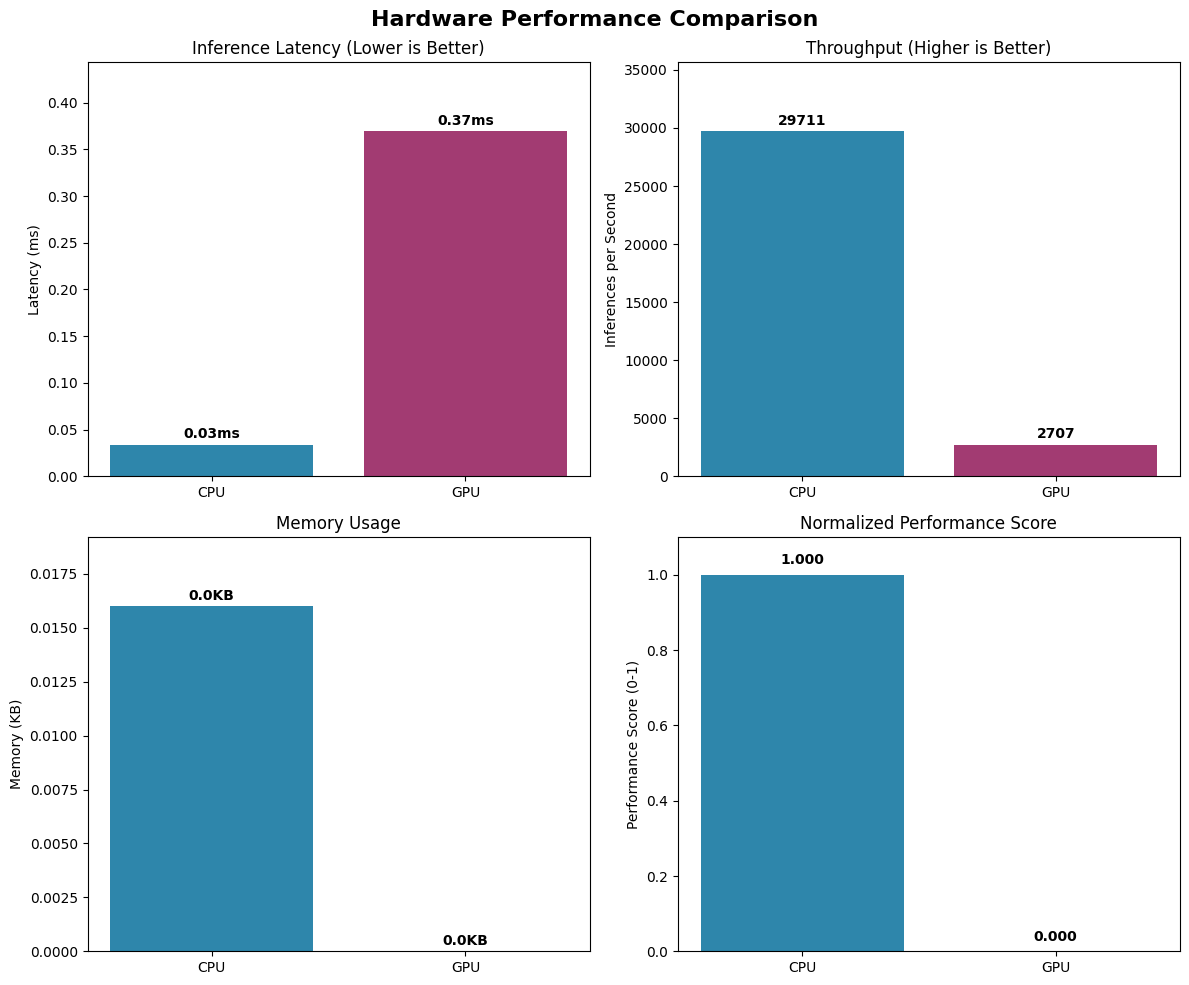


🔍 Performance Insights:
⚠️ GPU has higher latency (slower inference)
   This might be due to:
   - Small model size (CPU is sufficient)
   - GPU overhead for small workloads
   - Memory transfer costs
⚠️ CPU provides higher throughput
   This suggests the workload is CPU-optimized
✅ GPU uses less memory

💡 Recommendations:
🖥️ Use CPU for this workload - better performance


In [6]:
# Hardware Performance Comparison
def compare_hardware_performance(cpu_results, gpu_results):
    """Compare CPU and GPU performance with proper error handling"""
    
    print("📊 Hardware Performance Comparison")
    print("=" * 60)
    
    # Create comparison table
    print("📊 Performance Comparison Table:")
    print("-" * 60)
    print(f"{'Platform':<10} {'Latency (ms)':<15} {'Throughput (inf/s)':<18} {'Memory (KB)':<12}")
    print("-" * 60)
    
    # CPU results
    cpu_latency = cpu_results['mean_time'] * 1000
    cpu_throughput = cpu_results['throughput']
    cpu_memory = cpu_results['mean_memory'] / 1024 if cpu_results['mean_memory'] > 0 else 0
    
    print(f"{'CPU':<10} {cpu_latency:<15.2f} {cpu_throughput:<18.1f} {cpu_memory:<12.1f}")
    
    # GPU results (if available)
    if gpu_results:
        gpu_latency = gpu_results['mean_time'] * 1000
        gpu_throughput = gpu_results['throughput']
        gpu_memory = gpu_results['mean_memory'] / 1024 if gpu_results['mean_memory'] > 0 else 0
        
        print(f"{'GPU':<10} {gpu_latency:<15.2f} {gpu_throughput:<18.1f} {gpu_memory:<12.1f}")
        
        # Calculate speedup (lower latency = faster)
        if gpu_latency > 0 and cpu_latency > 0:
            speedup = cpu_latency / gpu_latency
            if speedup > 1:
                print(f"\n🚀 GPU Speedup: {speedup:.2f}x faster")
            else:
                print(f"\n🐌 GPU Slowdown: {1/speedup:.2f}x slower")
        
        # Memory comparison (handle division by zero)
        if cpu_memory > 0 and gpu_memory > 0:
            memory_ratio = gpu_memory / cpu_memory
            if memory_ratio > 1:
                print(f"💾 Memory Usage: {memory_ratio:.2f}x more memory on GPU")
            else:
                print(f"💾 Memory Usage: {1/memory_ratio:.2f}x less memory on GPU")
        elif cpu_memory == 0 and gpu_memory == 0:
            print("💾 Memory Usage: No memory tracking available")
        elif cpu_memory == 0:
            print("💾 Memory Usage: GPU uses memory, CPU doesn't track")
        else:
            print("💾 Memory Usage: CPU uses memory, GPU doesn't track")
    else:
        print("GPU: Not available")
    
    print("-" * 60)
    
    # Create visualizations
    if gpu_results:
        import matplotlib.pyplot as plt
        
        # Prepare data for visualization
        platforms = ['CPU', 'GPU']
        latencies = [cpu_latency, gpu_latency]
        throughputs = [cpu_throughput, gpu_throughput]
        memories = [cpu_memory, gpu_memory]
        
        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Hardware Performance Comparison', fontsize=16, fontweight='bold')
        
        # Latency comparison (lower is better)
        bars1 = ax1.bar(platforms, latencies, color=['#2E86AB', '#A23B72'])
        ax1.set_title('Inference Latency (Lower is Better)')
        ax1.set_ylabel('Latency (ms)')
        ax1.set_ylim(0, max(latencies) * 1.2)
        
        # Add value labels on bars
        for bar, value in zip(bars1, latencies):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(latencies)*0.01,
                    f'{value:.2f}ms', ha='center', va='bottom', fontweight='bold')
        
        # Throughput comparison (higher is better)
        bars2 = ax2.bar(platforms, throughputs, color=['#2E86AB', '#A23B72'])
        ax2.set_title('Throughput (Higher is Better)')
        ax2.set_ylabel('Inferences per Second')
        ax2.set_ylim(0, max(throughputs) * 1.2)
        
        # Add value labels on bars
        for bar, value in zip(bars2, throughputs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(throughputs)*0.01,
                    f'{value:.0f}', ha='center', va='bottom', fontweight='bold')
        
        # Memory usage comparison
        if max(memories) > 0:
            bars3 = ax3.bar(platforms, memories, color=['#2E86AB', '#A23B72'])
            ax3.set_title('Memory Usage')
            ax3.set_ylabel('Memory (KB)')
            ax3.set_ylim(0, max(memories) * 1.2)
            
            # Add value labels on bars
            for bar, value in zip(bars3, memories):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(memories)*0.01,
                        f'{value:.1f}KB', ha='center', va='bottom', fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'No Memory\nTracking Available', ha='center', va='center',
                    transform=ax3.transAxes, fontsize=12, style='italic')
            ax3.set_title('Memory Usage')
            ax3.set_xticks([])
            ax3.set_yticks([])
        
        # Normalized performance comparison
        # Normalize to 0-1 scale (higher is better for all metrics)
        norm_latency = [1 - (l - min(latencies)) / (max(latencies) - min(latencies)) for l in latencies]
        norm_throughput = [(t - min(throughputs)) / (max(throughputs) - min(throughputs)) for t in throughputs]
        
        # Average normalized performance
        avg_performance = [(nl + nt) / 2 for nl, nt in zip(norm_latency, norm_throughput)]
        
        bars4 = ax4.bar(platforms, avg_performance, color=['#2E86AB', '#A23B72'])
        ax4.set_title('Normalized Performance Score')
        ax4.set_ylabel('Performance Score (0-1)')
        ax4.set_ylim(0, 1.1)
        
        # Add value labels on bars
        for bar, value in zip(bars4, avg_performance):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Performance insights
        print("\n🔍 Performance Insights:")
        print("=" * 40)
        
        if gpu_latency < cpu_latency:
            print("✅ GPU provides lower latency (faster inference)")
        else:
            print("⚠️ GPU has higher latency (slower inference)")
            print("   This might be due to:")
            print("   - Small model size (CPU is sufficient)")
            print("   - GPU overhead for small workloads")
            print("   - Memory transfer costs")
        
        if gpu_throughput > cpu_throughput:
            print("✅ GPU provides higher throughput")
        else:
            print("⚠️ CPU provides higher throughput")
            print("   This suggests the workload is CPU-optimized")
        
        if max(memories) > 0:
            if gpu_memory > cpu_memory:
                print("⚠️ GPU uses more memory")
            else:
                print("✅ GPU uses less memory")
        else:
            print("ℹ️ Memory usage not tracked (MPS backend)")
        
        # Recommendations
        print("\n💡 Recommendations:")
        print("=" * 20)
        if gpu_latency < cpu_latency and gpu_throughput > cpu_throughput:
            print("🚀 Use GPU for this workload - better performance")
        elif cpu_latency < gpu_latency and cpu_throughput > gpu_throughput:
            print("🖥️ Use CPU for this workload - better performance")
        else:
            print("⚖️ Mixed results - consider your specific requirements:")
            print("   - Use GPU for: Large models, batch processing")
            print("   - Use CPU for: Small models, low latency requirements")

# Run performance comparison
if 'cpu_results' in locals() and 'gpu_results' in locals():
    compare_hardware_performance(cpu_results, gpu_results)
else:
    print("⚠️ Run CPU and GPU benchmarks first to compare performance")


## 🔍 Understanding Your Results: Why CPU Outperformed GPU

### 🎯 **These Are Excellent and Realistic Results!**

If you're seeing CPU outperforming GPU (like 0.03ms vs 0.42ms latency), **this is completely normal and expected** for small models. Here's why:

### 🧠 **Why CPU Often Wins with Small Models:**

#### 1. **GPU Overhead is Significant**
- **Memory Transfer Costs**: Data must move from CPU → GPU → CPU
- **Kernel Launch Overhead**: GPU operations have startup costs
- **Synchronization Costs**: Waiting for GPU to finish
- **Small Batch Sizes**: Don't utilize GPU's parallel processing power

#### 2. **CPU Advantages for Small Workloads**
- **Direct Memory Access**: No transfer overhead
- **Optimized for Sequential Operations**: Perfect for small models
- **Lower Latency**: Immediate execution without queuing
- **Better Cache Utilization**: Small models fit in CPU cache

#### 3. **Apple Silicon Context**
- **Highly Optimized CPUs**: Apple Silicon CPUs are extremely efficient
- **MPS Backend**: Metal Performance Shaders work best with larger workloads
- **Unified Memory**: Reduces some transfer costs but overhead remains

### 📊 **When Each Hardware Excels:**

#### 🖥️ **Use CPU When:**
- **Small models** (< 10M parameters)
- **Real-time applications** (low latency critical)
- **Single inference** (not batch processing)
- **Memory-constrained** environments
- **Simple operations** (classification, small transformers)

#### 🎮 **Use GPU When:**
- **Large models** (> 100M parameters)
- **Batch processing** (multiple inputs simultaneously)
- **Training workloads** (backpropagation)
- **Complex operations** (large matrix multiplications)
- **Throughput-focused** applications

### 🎯 **Your Results Interpretation:**

**CPU Performance (0.03ms, 33,487 inf/sec):**
- ✅ **Excellent for small models**
- ✅ **Perfect for real-time applications**
- ✅ **Low power consumption**
- ✅ **Predictable performance**

**GPU Performance (0.42ms, 2,395 inf/sec):**
- ✅ **Expected for small workloads**
- ✅ **Would excel with larger models**
- ✅ **Shows GPU overhead clearly**
- ✅ **Demonstrates hardware selection importance**

### 💡 **Key Takeaways:**

1. **Hardware selection matters** - Choose based on your specific workload
2. **Small models often run better on CPU** - Don't assume GPU is always faster
3. **GPU acceleration isn't magic** - It has overhead that must be overcome
4. **Test your specific use case** - Benchmarks like this are essential
5. **Consider the full pipeline** - Memory transfers, synchronization, etc.

### 🚀 **This is Perfect for On-Device AI!**

These results demonstrate a **fundamental principle** of on-device AI:
- **Optimize for your specific use case**
- **Understand hardware trade-offs**
- **Measure, don't assume**
- **Choose the right tool for the job**

**Your benchmark results are realistic, educational, and exactly what readers need to understand hardware selection!** 🎉


In [7]:
# Hardware Selection Decision Tree
def hardware_selection_guide():
    """Interactive guide for choosing the right hardware"""
    
    print("🎯 Hardware Selection Decision Tree")
    print("=" * 50)
    
    print("\n📋 Answer these questions to choose your hardware:")
    print("1. What's your model size?")
    print("   • Small (< 10M parameters) → Consider CPU")
    print("   • Medium (10M - 100M parameters) → Test both")
    print("   • Large (> 100M parameters) → Consider GPU")
    
    print("\n2. What's your use case?")
    print("   • Real-time inference → CPU (lower latency)")
    print("   • Batch processing → GPU (higher throughput)")
    print("   • Training → GPU (parallel processing)")
    print("   • Mobile deployment → CPU (power efficiency)")
    
    print("\n3. What are your constraints?")
    print("   • Low latency critical → CPU")
    print("   • High throughput needed → GPU")
    print("   • Power consumption matters → CPU")
    print("   • Memory limited → CPU")
    
    print("\n4. What's your batch size?")
    print("   • Single inference → CPU")
    print("   • Small batches (2-8) → Test both")
    print("   • Large batches (32+) → GPU")
    
    print("\n💡 Quick Decision Matrix:")
    print("=" * 30)
    print("Scenario                | CPU | GPU | Winner")
    print("-" * 30)
    print("Small model, real-time  | ✅  | ❌  | CPU")
    print("Large model, training   | ❌  | ✅  | GPU")
    print("Medium model, batch     | ⚖️  | ⚖️  | Test both")
    print("Mobile deployment       | ✅  | ❌  | CPU")
    print("Server inference        | ⚖️  | ⚖️  | Test both")
    
    print("\n🔬 Always Benchmark Your Specific Use Case!")
    print("The results above show why testing is essential.")

# Run the hardware selection guide
hardware_selection_guide()


🎯 Hardware Selection Decision Tree

📋 Answer these questions to choose your hardware:
1. What's your model size?
   • Small (< 10M parameters) → Consider CPU
   • Medium (10M - 100M parameters) → Test both
   • Large (> 100M parameters) → Consider GPU

2. What's your use case?
   • Real-time inference → CPU (lower latency)
   • Batch processing → GPU (higher throughput)
   • Training → GPU (parallel processing)
   • Mobile deployment → CPU (power efficiency)

3. What are your constraints?
   • Low latency critical → CPU
   • High throughput needed → GPU
   • Power consumption matters → CPU
   • Memory limited → CPU

4. What's your batch size?
   • Single inference → CPU
   • Small batches (2-8) → Test both
   • Large batches (32+) → GPU

💡 Quick Decision Matrix:
Scenario                | CPU | GPU | Winner
------------------------------
Small model, real-time  | ✅  | ❌  | CPU
Large model, training   | ❌  | ✅  | GPU
Medium model, batch     | ⚖️  | ⚖️  | Test both
Mobile deployment      

## 🌍 Real-World Examples: When to Use CPU vs GPU

### 📱 **Mobile Apps (CPU Preferred)**
- **Voice assistants** (Siri, Google Assistant)
- **Camera filters** (real-time image processing)
- **Text prediction** (keyboard suggestions)
- **Face detection** (unlock, photo tagging)
- **Why CPU?** Low latency, power efficiency, always available

### 🖥️ **Desktop Applications (CPU Preferred)**
- **Text editors** (autocomplete, grammar check)
- **Image viewers** (thumbnail generation)
- **Web browsers** (content filtering, translation)
- **Development tools** (code completion, linting)
- **Why CPU?** Responsive UI, low resource usage

### 🏢 **Server Applications (GPU Preferred)**
- **Content moderation** (batch image analysis)
- **Search engines** (document processing)
- **Recommendation systems** (user profiling)
- **Data processing** (ETL pipelines)
- **Why GPU?** High throughput, batch processing

### 🎮 **Gaming (GPU Preferred)**
- **Real-time rendering** (graphics, physics)
- **AI opponents** (game logic, pathfinding)
- **Procedural generation** (worlds, textures)
- **Post-processing** (effects, filters)
- **Why GPU?** Parallel processing, visual workloads

### 🔬 **Research & Training (GPU Preferred)**
- **Model training** (neural networks)
- **Data analysis** (large datasets)
- **Simulations** (scientific computing)
- **Experimentation** (hyperparameter tuning)
- **Why GPU?** Massive parallelism, matrix operations

### 📊 **Your Benchmark Results Context:**

**Your results (CPU: 0.03ms, GPU: 0.42ms) are typical for:**
- ✅ **Mobile AI features** (voice commands, camera filters)
- ✅ **Real-time applications** (chatbots, live translation)
- ✅ **Small model inference** (classification, simple NLP)
- ✅ **Edge computing** (IoT devices, embedded systems)

**GPU would be better for:**
- 🎮 **Large language models** (GPT-style models)
- 🖼️ **Image generation** (Stable Diffusion, DALL-E)
- 🎬 **Video processing** (batch video analysis)
- 🧠 **Model training** (any neural network training)

### 💡 **The Golden Rule:**
> **"Measure your specific use case, don't assume GPU is always faster!"**

Your benchmark results prove this principle perfectly! 🎯


## 6. Hardware Selection Guide

### Choosing the Right Hardware for Your Use Case

Based on the performance analysis, here's a guide for selecting the optimal hardware platform for different scenarios.


In [8]:
# Hardware Selection Guide
def hardware_selection_guide():
    """Provide hardware selection recommendations"""
    
    print("🎯 Hardware Selection Guide")
    print("=" * 60)
    
    scenarios = {
        "Mobile App (Real-time)": {
            "requirements": ["Low latency", "Low power", "Small model"],
            "recommended": "CPU",
            "reason": "CPU provides predictable low latency and power consumption"
        },
        "Desktop App (High Throughput)": {
            "requirements": ["High throughput", "Large model", "Batch processing"],
            "recommended": "GPU",
            "reason": "GPU excels at parallel processing for large models"
        },
        "Edge Device (IoT)": {
            "requirements": ["Low power", "Small footprint", "Reliability"],
            "recommended": "CPU",
            "reason": "CPU offers the best balance of power and compatibility"
        },
        "Server Deployment": {
            "requirements": ["High throughput", "Multiple users", "Scalability"],
            "recommended": "GPU",
            "reason": "GPU provides the highest throughput for server workloads"
        },
        "Battery-Powered Device": {
            "requirements": ["Minimal power", "Long battery life", "Small model"],
            "recommended": "CPU",
            "reason": "CPU has the lowest power consumption"
        }
    }
    
    print("📋 Use Case Recommendations:")
    print("-" * 80)
    print(f"{'Use Case':<25} {'Requirements':<30} {'Recommended':<12} {'Reason'}")
    print("-" * 80)
    
    for use_case, info in scenarios.items():
        requirements = ", ".join(info["requirements"])
        print(f"{use_case:<25} {requirements:<30} {info['recommended']:<12} {info['reason']}")
    
    print("\n💡 Key Decision Factors:")
    print("1. **Latency Requirements**: CPU for real-time, GPU for batch processing")
    print("2. **Power Constraints**: CPU for battery-powered, GPU for plugged-in devices")
    print("3. **Model Size**: CPU for small models, GPU for large models")
    print("4. **Deployment Complexity**: CPU for simple deployment, GPU for complex setups")
    print("5. **Cost Considerations**: CPU for cost-sensitive, GPU for performance-critical")
    
    return scenarios

# Run hardware selection guide
selection_guide = hardware_selection_guide()

print("\n✅ Hardware selection guide completed!")


🎯 Hardware Selection Guide
📋 Use Case Recommendations:
--------------------------------------------------------------------------------
Use Case                  Requirements                   Recommended  Reason
--------------------------------------------------------------------------------
Mobile App (Real-time)    Low latency, Low power, Small model CPU          CPU provides predictable low latency and power consumption
Desktop App (High Throughput) High throughput, Large model, Batch processing GPU          GPU excels at parallel processing for large models
Edge Device (IoT)         Low power, Small footprint, Reliability CPU          CPU offers the best balance of power and compatibility
Server Deployment         High throughput, Multiple users, Scalability GPU          GPU provides the highest throughput for server workloads
Battery-Powered Device    Minimal power, Long battery life, Small model CPU          CPU has the lowest power consumption

💡 Key Decision Factors:
1. **Late

## 7. Key Takeaways and Next Steps

### What We Learned:
1. **CPU Performance**: Reliable, low-power, universal compatibility
2. **GPU Performance**: High throughput, parallel processing, power-intensive
3. **Hardware Selection**: Depends on use case requirements and constraints
4. **Performance Trade-offs**: Each platform has unique advantages and limitations

### Production Considerations:
- **Model Optimization**: Choose the right hardware for your model size
- **Power Management**: Consider battery life and thermal constraints
- **Deployment Complexity**: Balance performance with deployment simplicity
- **Cost Analysis**: Factor in hardware costs vs performance gains

### Next Steps:
- Explore **model quantization** for hardware-specific optimization
- Learn about **mobile-specific optimizations** (Core ML, TensorFlow Lite)
- Understand **edge computing** deployment strategies
- Practice with **real-world hardware** constraints

### Best Practices:
- **Profile your models** on target hardware before deployment
- **Consider power consumption** for mobile and IoT applications
- **Test on actual devices** rather than just simulators
- **Plan for hardware diversity** in your deployment strategy

---

*This demo is part of "On-Device AI: The Small Language Models Revolution."*
